c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(9, 1, 0)   Log Likelihood                  56.893
Date:                Sat, 12 Nov 2022   AIC                            -93.787
Time:                        00:22:34   BIC                            -72.515
Sample:                             0   HQIC                           -85.435
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4002      0.128     -3.127      0.002      -0.651      -0.149
ar.L2         -0.1799      0.156     -1.150      0.250      -0.487       0.127
ar.L3         -0.1140      0.161     -0.710      0.4

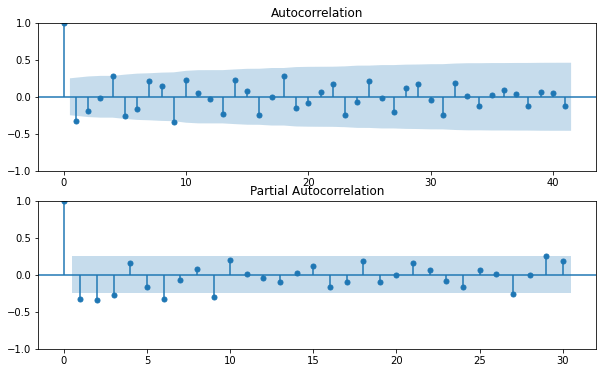

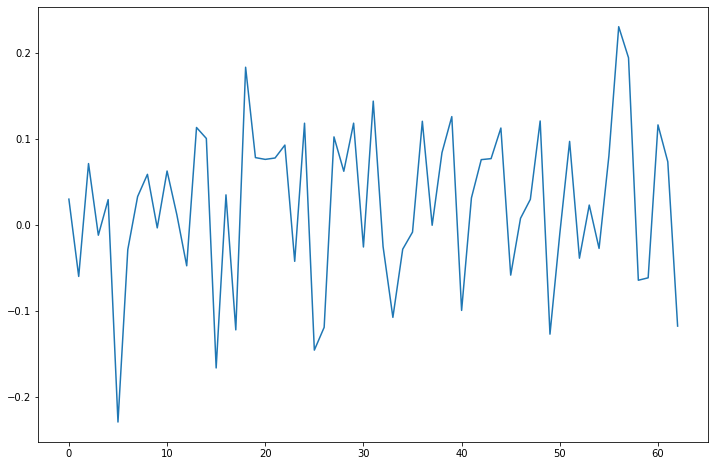

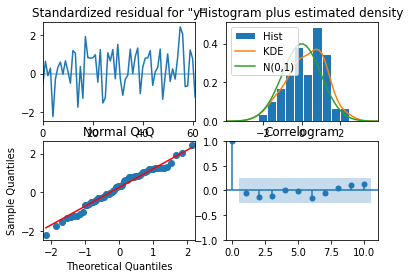

   Predicted Sales
1         1.797845
2         2.787714
3         3.852308
4         4.883385
5         5.838264
ADF-Test Result:
Test Statistic            2.965181
P-value                   0.999768
Lags Used                 6.000000
nobs                     56.000000
Critical Value at 1%     -2.606822
Critical Value at 5%     -1.946692
Critical Value at 10%    -1.612798
dtype: float64
-------------------------------------
ADF-Test Result:
Test Statistic           -3.895122
P-value                   0.000110
Lags Used                 3.000000
nobs                     58.000000
Critical Value at 1%     -2.605366
Critical Value at 5%     -1.946471
Critical Value at 10%    -1.612917
dtype: float64


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.



AttributeError: module 'statsmodels.tsa.api' has no attribute 'ARMA'

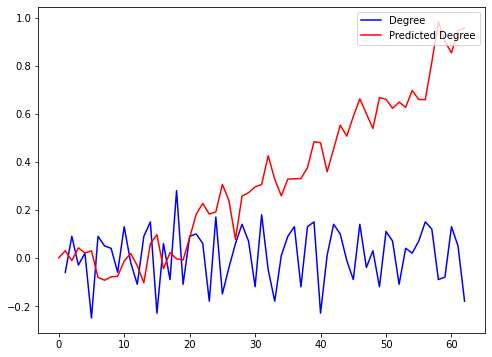

In [92]:
# 加载数据
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, pacf

df = pd.read_excel('2022_HiMCM_Data-B-co2.xlsx',sheet_name="origin")
year = df['Year'].to_numpy()
# ppm = df['PPM']
degree = df['Degree']

fig = go.Figure()
fig.add_traces(go.Scatter(x=year, y=degree.diff(1), mode = "lines", name = "Degree_diff(1)"))
fig.add_traces(go.Scatter(x=year, y=degree, mode = "lines", name = "Degree"))

fig.update_layout( 
        title='OOOO',
        title_x=0.5,
        autosize=True,
        # width=2200,
        # height=1000,
    )

fig.show()


# https://blog.csdn.net/weixin_49583390/article/details/121914303
# https://blog.csdn.net/fs01234/article/details/88914930  ##### ARIMA（p,d,q）模型原理及其实现 --------python

#——————————————————————————————————————————————————————————————————————————————————————

# ARIMA模型分析：
# 先把ACF图和PACF图画出来看看：
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(degree.diff(1).dropna().to_numpy(), lags=41, ax=ax1)  # 注意：要去掉第1个空值

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(degree.diff(1).dropna(),  lags=30, ax=ax2)  # 注意：要去掉第1个空值
# 判断：ACF图在2之后截尾，而PACF拖尾。模型可以由MA(2)→ARIMA(0,1,9).
# MA模型：自相关系数截尾，偏自相关函数拖尾

# 建立ARIMA模型

# https://wiki.mbalib.com/wiki/%E6%9C%80%E5%B0%8F%E4%BA%8C%E4%B9%98%E6%B3%95
model = sm.tsa.ARIMA(degree.dropna().to_numpy(), order=(9,1,0)).fit()  # 默认使用最小二乘generalized least squares(GLS)，‘mle’是极大似然估计
# model = sm.tsa.ARIMA(degree.diff(1).dropna().to_numpy(), order=(0,1,9)).fit()  # 默认使用最小二乘generalized least squares(GLS)，‘mle’是极大似然估计

print(model.summary())

resid = model.resid
plt.figure(figsize=(12,8))
plt.plot(resid)

print(stats.normaltest(resid))

model.plot_diagnostics()
plt.show()

# stats.probplot(resid, dist="norm", plot=plt)
# plt.show()
# plt.hist(resid, bins=50)
# plt.show()

# 画图比较一下预测值和真实观测值之间的关系
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(degree.diff(1), color='blue', label='Degree')
ax.plot(model.fittedvalues, color='red', label='Predicted Degree')
plt.legend(loc='upper right')

# 最后，把预测值还原为原始数据的形式，预测值是差分数值，需要转化

def forecast(step, var, modelname):
    diff = list(modelname.predict(len(var)-1, len(var)-1+step, dynamic=True))
    prediction = [var[len(var)-1]]
    seq = [var[len(var)-1], *diff]
    for i in range(step):
        v = prediction[i]+seq[i+1]
        prediction.append(v)

    prediction = pd.DataFrame({'Predicted Sales': prediction})
    return prediction[1:]  # 第一个值是原序列最后一个值，故第二个值是预测值。


print(forecast(5, degree, model))

# # 还可以再进行自相关系数的白噪声检验：
# r, q, p = sm.tsa.acf(degree.diff(1).values.squeeze(), qstat=True)  # squeeze: 除去size为1的维度
# # np.c_是按行连接两个矩阵，把两矩阵左右相加，要求行数相等，类似pandas的merge()
# mat = np.c_[range(1, 41), r[1:], q, p]
# table = pd.DataFrame(mat, columns=['lag', 'AC', 'Q', 'Prob(>Q)'])
# LB_result = table.iloc[[5, 11, 17]]
# LB_result.set_index('lag', inplace=True)
# LB_result
# # P值均大于0.05，表明白噪声检验不显著，所以数据经过一阶差分后平稳。

# 单位根检验(原假设H0：时间序列具有单位根（不平稳）)：
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?
# highlight=adfuller#statsmodels.tsa.stattools.adfuller


def DFTest(sales, regression, maxlag, autolag='AIC'):
    print("ADF-Test Result:")
    dftest = adfuller(sales, regression=regression,
                      maxlag=maxlag, autolag=autolag)

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'P-value',
                                'Lags Used', 'nobs'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value at %s' % key] = value
    print(dfoutput)

# regression可以根据模型形式指定为：
# ‘c'：仅常数，默认；’ct‘：常数和长期趋势；’ctt’：常数、线性和二次曲线趋势；‘nc’：无常数趋势。


DFTest(degree, regression='nc',
       maxlag=6, autolag='AIC')  # 对原始数据进行单位根检验

print(37*'-')
DFTest(degree.diff(1).dropna(),
       regression='nc', maxlag=5, autolag='AIC')
# 结论：一阶差分后平稳。

# 利用BIC最小的模型作为识别的依据：
order_p, order_q, bic = [], [], []
model_order = pd.DataFrame()
for p in range(4):
    for q in range(4):
        arma_model = sm.tsa.ARMA(degree.diff(1).dropna(),
                                 (p, q)).fit()
        order_p.append(p)
        order_q.append(q)
        bic.append(arma_model.bic)
        print('The BIC of ARMA(%s,%s) is %s' % (p, q, arma_model.bic))

model_order['p'] = order_p
model_order['q'] = order_q
model_order['BIC'] = bic
P = list(model_order['p'][model_order['BIC'] == model_order['BIC'].min()])
Q = list(model_order['q'][model_order['BIC'] == model_order['BIC'].min()])
print('\n最好的模型是ARMA(%s,%s)' % (P[0], Q[0]))

# 模型参数估计及检验：
model = sm.tsa.ARMA(sales['Sales'].diff(1).iloc[1:92].dropna(),
                    (0, 2)).fit(method='css')  # 使用最小二乘，‘mle’是极大似然估计
params = model.params
tvalues = model.tvalues
pvalues = model.pvalues
result_mat = pd.DataFrame(
    {'Estimate': params, 't-values': tvalues, 'pvalues': pvalues})
result_mat  # 注意：这里得到的是-θ的结果（Xt=at-θ1a(t-1)-θ2a(t-2)）。从t值来看是显著的。

model.aic
print('方差估计值是：%f' % model.sigma2)

# 如果ARMA模型估计的好，应当使得估计值后的残差项是白噪声。下面对模型的残差项进行白噪声检验：
resid = model.resid
r, q, p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
# np.c_是按行连接两个矩阵，把两矩阵左右相加，要求行数相等，类似pandas的merge()
mat_res = np.c_[range(1, 41), r[1:], q, p]
table = pd.DataFrame(mat_res, columns=['to lag', 'AC', 'Q', 'Prob(>Q)'])
LB_result_res = table.iloc[[5, 11, 17, 23]]
LB_result_res.set_index('to lag', inplace=True)
LB_result_res
# 原假设为残差是白噪声。

# 再看一下正态性：
sm.ProbPlot(resid, stats.t, fit=True).ppplot(line='45')
sm.ProbPlot(resid, stats.t, fit=True).qqplot(line='45')
plt.show()

plt.figure()
x = pd.Series(resid)
p1 = x.plot(kind='kde')  # 可以是’line’, ‘bar’, ‘barh’, ‘kde’.kde是密度图。
p2 = x.hist(normed=True)
plt.grid(True)
plt.show()

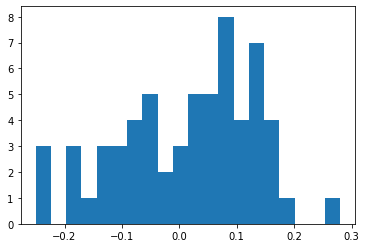

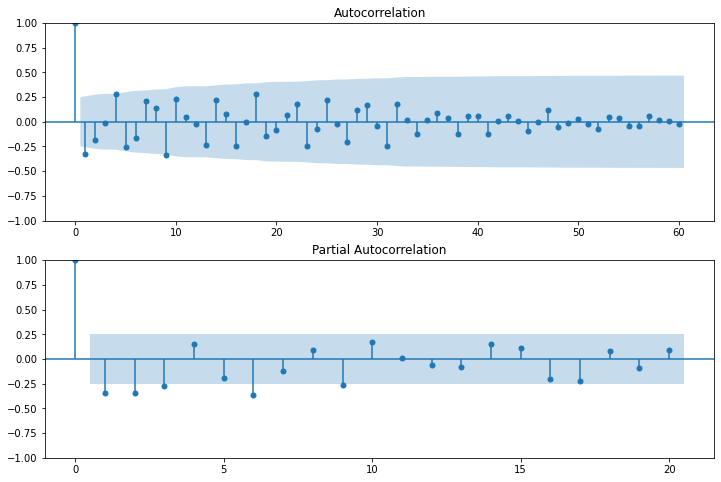

<Figure size 864x576 with 0 Axes>

原始序列的ADF检验结果为： (1.5746704497600132, 0.9977795598631019, 9, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, -85.88087356881391)
一阶差分序列的ADF检验结果为： (-4.25397083522795, 0.0005331991807277259, 8, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, -85.73263464577764)
差分序列的白噪声检验结果：     lb_stat  lb_pvalue
1  6.880686   0.008713


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                 Degree   No. Observations:                   63
Model:                 ARIMA(1, 1, 9)   Log Likelihood                  57.526
Date:                Sat, 12 Nov 2022   AIC                            -93.053
Time:                        21:58:11   BIC                            -69.654
Sample:                             0   HQIC                           -83.866
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6830      0.459     -1.489      0.136      -1.582       0.216
ma.L1          0.2349      0.511      0.459      0.646      -0.768       1.237
ma.L2         -0.4166      0.223     -1.868      0.0

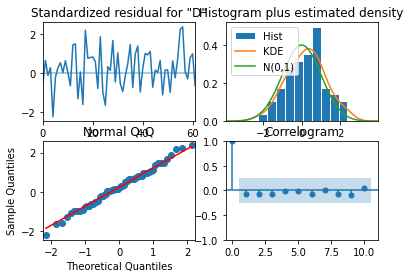

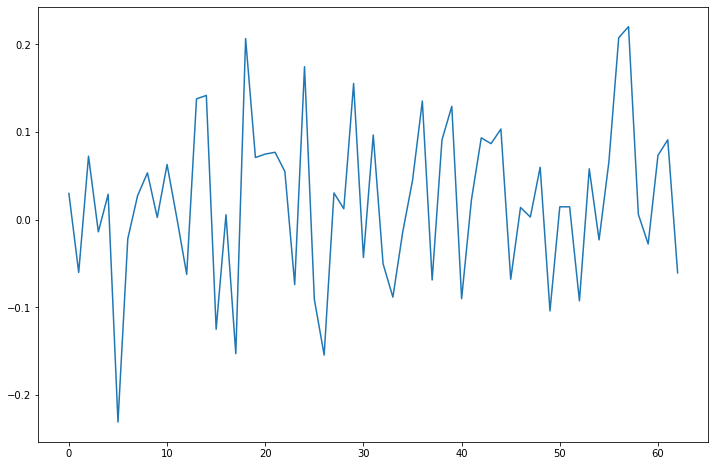

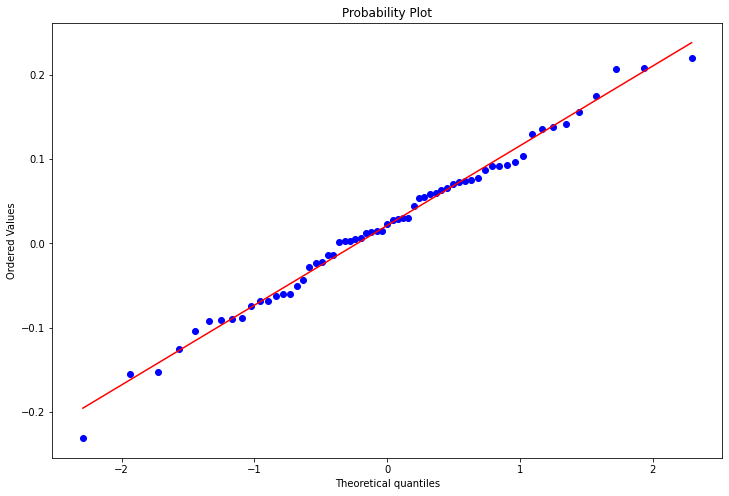

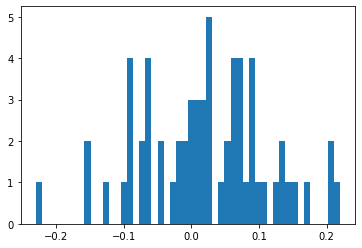

2.016994178202715


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm
from scipy import stats
# import matplotlib.pyplot as plt/
import plotly.graph_objects as go
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


df = pd.read_excel('2022_HiMCM_Data-B-co2.xlsx', sheet_name="origin")
year = df['Year'].to_numpy()
# ppm = df['PPM']
degree = df['Degree']

fig = go.Figure()
fig.add_traces(go.Scatter(x=year, y=degree.diff(1),
                          mode="lines", name="Degree_diff(1)"))
fig.add_traces(go.Scatter(x=year, y=degree, mode="lines", name="Degree"))

fig.update_layout(
    title='OOOO',
    title_x=0.5,
    autosize=True,
    # width=2200,
    # height=1000,
)

fig.show()
# _____________________________________

plt.hist(degree.diff(1), bins=20)

# print("-"*50, "一阶差分数据ACF与PACF", "-"*50)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(degree.diff(1).dropna().values, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
figpac = plt.figure(figsize=(12, 8))

figpac = plot_pacf(degree.diff(1).dropna(), method='ols', lags=20, ax=ax2)
plt.show()

# ——————————————————————————————————————————————————————————————————————————
#未差分平稳性检测（ADF检验、单位根检验）
from  statsmodels.tsa.stattools  import  adfuller  as  ADF
print(u'原始序列的ADF检验结果为：',  ADF(degree))

#一阶差分平稳性检测（ADF检验、单位根检验）
print(u'一阶差分序列的ADF检验结果为：',  ADF(degree.diff(1).dropna()))

#返回值依次为adf、pvalue、usedlag、nobs、critical  values、icbest、regresults、resstore
# p<0.05时表示稳定

from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(degree.diff(1).dropna(), lags= 1)) #返回统计量和 p 值

# ——————————————————————————————————————————————————————————————————————————

# 拟合
arima910 = ARIMA(degree,order=(1,1,9)).fit()
print(arima910.summary())

arima910.plot_diagnostics()

# ——————————————————————————————————————————————————————————————————————————
# https://mp.weixin.qq.com/s/rPeWlC7EdNto57ZsFvZ-ug

#残差
resid=arima910.resid
plt.figure(figsize=(12,8))
plt.plot(resid)
print(stats.normaltest(resid))#检验序列残差是否为正态分布    pvalue=0.00028625258929196876   <  0.05  拒绝原假设 认为残差符合正太分布
plt.figure(figsize=(12,8))

stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=50)
plt.show()

from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(arima910.resid.values))     #DW检验：靠近2——正常；靠近0——正自相关；靠近4——负自相关

# ——————————————————————————————————————————————————————————
# pred_ci = pred.conf_int()

# # 绘制原数据和预测数据对比图
# ## 可视化模型的在测试集上的预测结果
# model.plot_predict(h=degree.shape[0], ## 往后预测多少步
#                    oos_data=degree,  ## 测试数据集
#                    past_values=degree.shape[0], ## 图像显示训练集的多少数据 
#                    figsize=(15,5))
# ## 可视化原始数据
# plt.figure(figsize=(12,8))
# plt.xlabel("Time")
# plt.ylabel("Temperature")
# plt.show()

# 获取未来500步的预测
pred_uc = arima910.get_forecast(steps=500)

# 获取预测的置信区间
pred_ci = pred_uc.conf_int()




# print("在测试集上mean absolute error:",mean_absolute_error(testdata.C02,C02pre.C02))
# print("在测试集上mean squared error:",mean_squared_error(testdata.C02,C02pre.C02))
